# 使用卷积神经网络 `CNN` 的手写识别

## 卷积层

### 卷积

概率论中的卷积操作表示两个分布的联合分布的边缘概率分布，信号与系统中卷积可以表征线性系统对输入的响应

在图像处理中，卷积是对图像的特征的提取。

当被卷积的部分和卷积核相似度较高时，卷积操作的结果就相对较大，这样便实现了特征的量化。

### 卷积操作

使用一个卷积核对图像的一小块进行卷积计算，得到的值可以形成一个新的二维数组

每一个卷积核对图像进行一次卷积操作，都会形成一个二维数组，这些二维数组放在一起，被称为不同的通道`channel`
> `channel`这个概念类似于图像的`RGB channel`，不过这里表示的不是像素的颜色分量，而是特征分量

这样，图像被转换了包含不同特征分布的3维数组

---

## 池化层

卷积层产生的特征数量很多，池化层是对卷积层特征的采样，以减少计算量

`MaxPool`是将范围内最大值选取为采样的结果；这可以保持大部分显著特征不丢失，传到下一层

---

经过池化层，数据仍是三维数组。需要将数组转化为向量，将维度展开即可

---

## 理论结束，实践开始

In [24]:
from typing import override
from pathlib import Path
from pickle import load, dump

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.sgd import SGD

import matplotlib.pyplot as plt

## 还是以前用过的加载数据

注意这里输出的数据格式有一点变化，图片由1维变为3维：[ 通道，高，宽 ]

In [25]:
class MnistDataset2D(Dataset):
    @override
    def __init__(self, x:torch.Tensor, y:torch.Tensor) -> None:
        super().__init__()
        if len(x) != len(y):
            raise IndexError('len(x) != len(y)')
        self.x = x
        self.y = y
        return
    
    @override
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[index].unsqueeze(0), self.y[index]
    
    @override
    def __len__(self) -> int:
        return len(self.x)
    
    
def readDataset(name:str) -> MnistDataset2D:
    fullImgPath = f'./mnistData/{name}-images.idx3-ubyte'
    fullLabelPath = f'./mnistData/{name}-labels.idx1-ubyte'

    with open(fullImgPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2051:
            raise ValueError(f'head magic number not equal to 2051: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        dataRow = int.from_bytes(f.read(4))
        dataCol = int.from_bytes(f.read(4))
        
        img = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber*dataRow*dataCol,
            offset=0,
            )
    img.shape = (dataNumber, dataRow, dataCol)
    imgTensor = torch.from_numpy(img).type(torch.float32) / 255
        
    with open(fullLabelPath, 'rb') as f:
        magic = int.from_bytes(f.read(4))
        if magic != 2049:
            raise ValueError(f'head magic number not equal to 2049: gotten={magic}')
        
        dataNumber = int.from_bytes(f.read(4))
        
        label = np.fromfile(
            file=f, 
            dtype=np.uint8, 
            count=dataNumber,
            offset=0,
            )

    labelOnehotTensor = torch.zeros((len(label), 10), dtype=torch.float32)
    for i,j in zip(label, labelOnehotTensor):
        j[i] = 1
    
    return MnistDataset2D(imgTensor, labelOnehotTensor)

## 使用卷积的模型

这里把第一层的全连接层改为了卷积层+池化层

将池化层的输出进行展平，输入到第二层（全连接层）

第二层的输出改为了32

In [34]:
model = nn.Sequential(

    nn.Conv2d(1, 8, 3, 1, 1, dtype=torch.float32),
    nn.MaxPool2d(2),
    nn.Flatten(1,3),
    nn.ReLU(),
    nn.Linear(14 * 14 * 8, 32, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(32, 16, True, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(16, 10, True, dtype=torch.float32),
)

def predict(input):
    return torch.softmax(model(input), dim=1)

criterion = nn.CrossEntropyLoss()
optimisor = SGD(model.parameters(), lr=0.01, weight_decay=0.001)

## 加载训练数据集

In [27]:

trainSetPath = Path("./trainDataset2D.pickle")

if trainSetPath.exists():
    with open(trainSetPath, "rb") as f:
        trainSet = load(f)
else:
    trainSet = readDataset("train")
    with open(trainSetPath, "wb") as f:
        dump(trainSet, f)

trainDataLoader = DataLoader(trainSet, 20, True)

## 加载已有模型

In [33]:

modelFile = Path("./modelWithCNN.pickle")

if modelFile.exists():
    with open(modelFile, "rb") as f:
        model = load(f)
    print(f"已加载已有模型：{modelFile}")


In [ ]:

epochs = 10
for epoch in range(epochs):
    for i, data in enumerate(trainDataLoader):
        output = model(data[0])
        loss: torch.Tensor = criterion(output, data[1])
        optimisor.zero_grad()
        loss.backward()
        optimisor.step()
        if (i + 1) % 100 == 0:
            print(f"loss:{float(loss)}")
    for i in optimisor.param_groups:
        i["lr"] *= 0.3

print("训练完成")

with open(modelFile, "wb") as f:
    dump(model, f)

## 对训练结果进行测试

只是改动了一层，将第一层改为卷积，识别的效果大大提高，可以达到90%以上

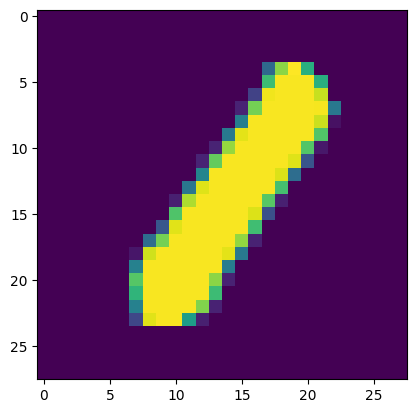

Target: 1
Predict: 8
tensor([False])
--------------------


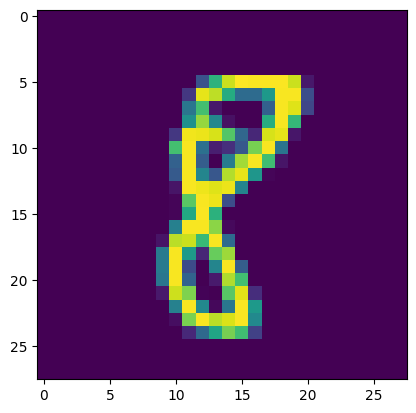

Target: 8
Predict: 8
tensor([True])
--------------------


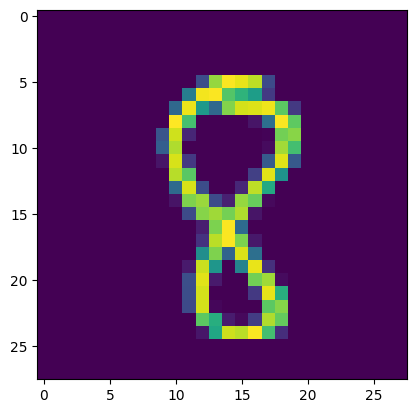

Target: 8
Predict: 8
tensor([True])
--------------------


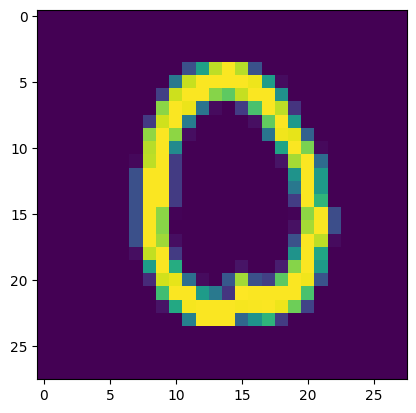

Target: 0
Predict: 0
tensor([True])
--------------------


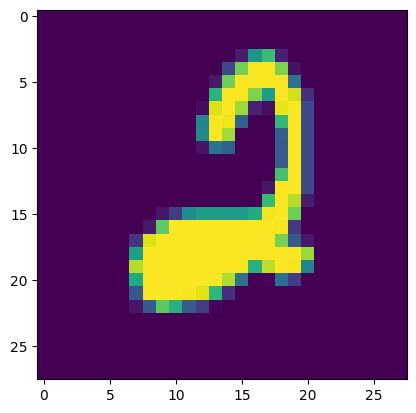

Target: 2
Predict: 2
tensor([True])
--------------------


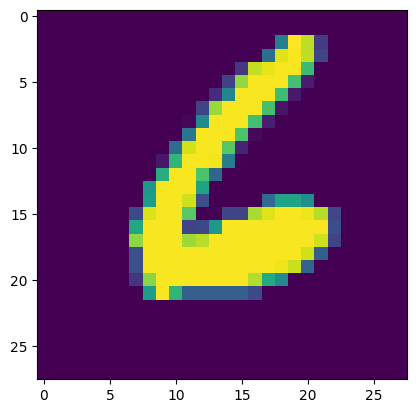

Target: 6
Predict: 6
tensor([True])
--------------------


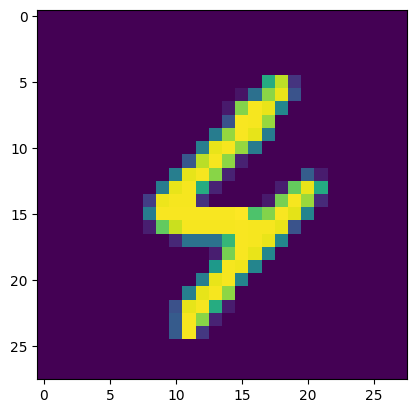

Target: 4
Predict: 4
tensor([True])
--------------------


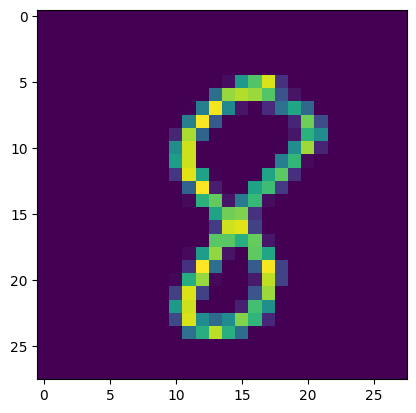

Target: 8
Predict: 8
tensor([True])
--------------------


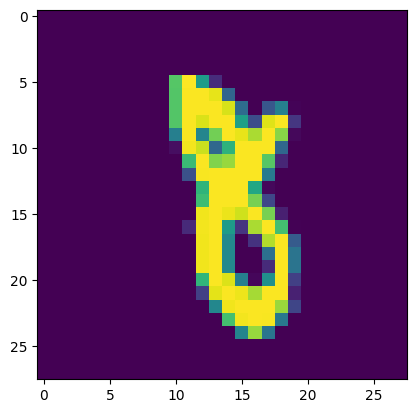

Target: 8
Predict: 1
tensor([False])
--------------------


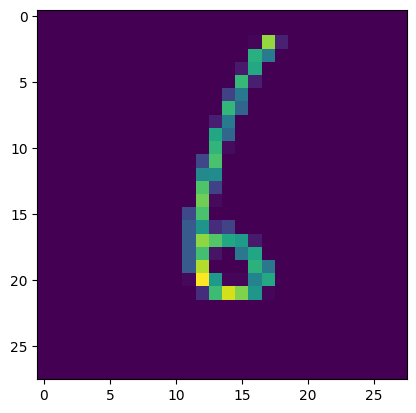

Target: 6
Predict: 6
tensor([True])
--------------------
正确率92.58%


In [36]:
testSet = readDataset("t10k")
testDataLoader = DataLoader(testSet, batch_size=1, shuffle=True)

showCount = 0

correctorchount = 0
for data in testDataLoader:
    output: torch.Tensor = model(data[0])
    correction: torch.Tensor = output.argmax(1) == data[1].argmax(1)
    correctorchount += int(correction.sum(dtype=torch.int32))
    if showCount < 10:
        showCount += 1
        plt.imshow(data[0].reshape((28,28)))
        plt.show()
        print(f'Target: {data[1].argmax()}')
        print(f'Predict: {output.argmax()}')
        print(correction)
        print('-'*20)


print(f"正确率{correctorchount/100}%")